In [8]:
import warnings
import sys
import os

import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedGroupKFold, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score, precision_recall_curve, auc

import xgboost as xgb  

notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))
if project_root not in sys.path:
    print(f"Adicionando '{project_root}' ao sys.path")
    sys.path.append(project_root)

from src.data_processing import load_and_clean_data, load_data_and_setup_env
from src.feature_engineering import create_advanced_features


warnings.filterwarnings("ignore")

In [9]:
"""CARREGANDO OS DADOS
"""

base_pagamentos_dev, path_cadastral, path_base_info, path_processed, base_cadastral, base_info, path_raw, path_assets = load_data_and_setup_env(project_root)

Caminho absoluto para os dados brutos: d:\Users\pflss\source\repos\datarisk-case-ds-junior\default-risk\data/raw
Verificando diretório: d:\Users\pflss\source\repos\datarisk-case-ds-junior\default-risk\assets
Verificando diretório: d:\Users\pflss\source\repos\datarisk-case-ds-junior\default-risk\data/processed/

Tentando carregar dados de: d:\Users\pflss\source\repos\datarisk-case-ds-junior\default-risk\data/raw/base_pagamentos_desenvolvimento.csv

Dados carregados com sucesso!


# **Modelagem, Validação e Inferência**

## 1. Objetivo

Após uma fase intensiva de Análise Exploratória e Engenharia de _Features_, que nos proporcionou um profundo entendimento do negócio e um _dataset_ enriquecido, chegamos à etapa final e decisiva deste projeto: a **construção da solução preditiva**.

O objetivo deste _notebook_ é desenvolver e validar rigorosamente um modelo de _Machine Learning_ capaz de prever a **probabilidade de inadimplência** de um cliente. O entregável final será o arquivo `submissao_case.csv`, contendo as predições para a base de teste fornecida.

## 2. A Nossa Estratégia de Modelagem e Validação

Para garantir que nosso modelo seja não apenas performático, mas também **robusto** e **confiável**, adotaremos uma estratégia metodológica clara.

### 2.1 O Desafio: Avaliação vs. Inferência Final

O _case_ nos fornece dois conjuntos de dados de pagamentos:
* `base_pagamentos_desenvolvimento.csv`: Nosso dataset de **desenvolvimento**, para o qual temos o histórico completo, incluindo as datas de pagamento que nos permitem calcular a inadimplência.
* `base_pagamentos_teste.csv`: Nosso dataset de **teste final** ("produção"), para o qual **não temos o desfecho**.

A questão central é: **Como podemos avaliar e otimizar nosso modelo se não temos o gabarito da base de teste final?**

A resposta está na **validação local rigorosa**. Antes de aplicarmos nosso modelo ao desafio final, precisamos simular o "dia do exame" usando apenas os dados de desenvolvimento.

### 2.2 Plano de Ação

Nosso fluxo de trabalho será dividido em três fases macro:

**Fase 1: Preparação e Validação do Modelo (Ambiente de Desenvolvimento)**

1.  **Geração dos Dados:** Utilizaremos nossas funções customizadas em `src/` para processar a base de desenvolvimento e gerar o dataset `X_dev` (features) e `y_dev` (alvo `INADIMPLENTE`).

2.  **Seleção do Modelo via Validação Cruzada (Cross-Validation):** Em vez de um simples `train_test_split`, empregaremos a **Validação Cruzada Estratificada**. Esta técnica, mais consistennte, divide os dados de desenvolvimento em múltiplos "_folds_" (partes), treinando e testando o modelo várias vezes, garantindo que todas as transações de um mesmo `ID_CLIENTE` fiquem sempre juntas no mesmo _fold_ (ou no grupo de treino, ou no de validação) para previnir _data leakage_. Isso nos dá uma estimativa muito mais estável e confiável da sua performance real.
    * **Modelo Baseline:** Avaliaremos a performance média de uma **Regressão Logística**.
    * **Modelo Avançado:** Avaliaremos a performance média de um modelo mais sofisticado, como o **XGBoost**.

3.  **Seleção do Campeão:** Com base na média das métricas da Validação Cruzada (foco em AUC-ROC e Recall), selecionaremos o algoritmo vencedor.

**Fase 2: Treinamento Final**

4.  **Retreinamento:** Uma vez escolhido o melhor modelo (ex: XGBoost) e seus melhores parâmetros, iremos **retreiná-lo utilizando 100% dos nossos dados de desenvolvimento** (`X_dev` e `y_dev`). O objetivo é dar ao nosso modelo final todo o conhecimento possível antes de enfrentar o desafio real.

**Fase 3: Geração da Submissão Final**

5.  **Preparação dos Dados de Teste:** Aplicaremos **exatamente os mesmos passos de processamento e engenharia de features** na base `base_pagamentos_teste.csv`.
6.  **Inferência:** Usaremos o nosso modelo final, treinado na Fase 2, para fazer as predições na base de teste preparada, utilizando o método `.predict_proba()` para obter as probabilidades.
7.  **Criação do Arquivo Final:** Montaremos o arquivo `submissao_case.csv` no formato exato especificado no desafio.

---

Este plano metodológico garante que cada passo seja deliberado, justificável e que o resultado final seja fruto de um processo de validação rigoroso, pois nosso intuito é definir uma estratégia de trabalho de alto nível para uma tarefa delicada.

## **Primeira fase de modelagem:**

In [10]:
print("### Executando pipeline de dados ###")
df_clean = load_and_clean_data(path_raw)
df_model_ready = create_advanced_features(df_clean)

'''Para o GroupKFold, precisamos da coluna de grupos (ID_CLIENTE) antes de dropá-la
'''
groups = df_model_ready['ID_CLIENTE']
X = df_model_ready.drop(['INADIMPLENTE', 'ID_CLIENTE'], axis=1)
y = df_model_ready['INADIMPLENTE']
print(f"Dataset pronto com {X.shape[0]} amostras e {X.shape[1]} features.")


'''Validação com StratifiedGroupKFold 
'''
print("\n--- Iniciando Validação Cruzada MAIS ROBUSTA (StratifiedGroupKFold) ---")
N_SPLITS = 5
sgkf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

results = {
    'Logistic Regression': {'auc': [], 'recall': [], 'precision': []},
    'XGBoost': {'auc': [], 'recall': [], 'precision': []}
}

'''Loop de Validação Cruzada. O método split agora precisa dos grupos
'''
for fold, (train_index, val_index) in enumerate(sgkf.split(X, y, groups=groups)):
    print(f"\n--- Processando Fold {fold+1}/{N_SPLITS} ---")
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # ===> Modelo Baseline: Regressão Logística
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    log_reg = LogisticRegression(class_weight='balanced', random_state=42, max_iter=2000)
    log_reg.fit(X_train_scaled, y_train)
    
    y_pred_proba_lr = log_reg.predict_proba(X_val_scaled)[:, 1]
    y_pred_class_lr = log_reg.predict(X_val_scaled)
    
    results['Logistic Regression']['auc'].append(roc_auc_score(y_val, y_pred_proba_lr))
    results['Logistic Regression']['recall'].append(recall_score(y_val, y_pred_class_lr))
    results['Logistic Regression']['precision'].append(precision_score(y_val, y_pred_class_lr))

    # ===> Modelo Avançado: XGBoost
    scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
    xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', scale_pos_weight=scale_pos_weight, use_label_encoder=False, random_state=42)
    xgb_model.fit(X_train, y_train)
    
    y_pred_proba_xgb = xgb_model.predict_proba(X_val)[:, 1]
    y_pred_class_xgb = xgb_model.predict(X_val)
    
    results['XGBoost']['auc'].append(roc_auc_score(y_val, y_pred_proba_xgb))
    results['XGBoost']['recall'].append(recall_score(y_val, y_pred_class_xgb))
    results['XGBoost']['precision'].append(precision_score(y_val, y_pred_class_xgb))


print("\n\n### Resultado Final da Validação Definitiva (StratifiedGroupKFold) ###")
for model_name, metrics in results.items():
    print(f"\nModelo: {model_name}")
    print(f"  AUC Médio:       {np.mean(metrics['auc']):.4f} (+/- {np.std(metrics['auc']):.4f})")
    print(f"  Recall Médio:    {np.mean(metrics['recall']):.4f} (+/- {np.std(metrics['recall']):.4f})")
    print(f"  Precision Médio: {np.mean(metrics['precision']):.4f} (+/- {np.std(metrics['precision']):.4f})")

### Executando pipeline de dados ###
Iniciando pipeline de processamento de dados para o conjunto de desenvolvimento...
Processamento de dados concluído.
Iniciando pipeline de engenharia de features...
Engenharia de features concluída.
Dataset pronto com 77374 amostras e 28 features.

--- Iniciando Validação Cruzada MAIS ROBUSTA (StratifiedGroupKFold) ---

--- Processando Fold 1/5 ---

--- Processando Fold 2/5 ---

--- Processando Fold 3/5 ---

--- Processando Fold 4/5 ---

--- Processando Fold 5/5 ---


### Resultado Final da Validação Definitiva (StratifiedGroupKFold) ###

Modelo: Logistic Regression
  AUC Médio:       0.6375 (+/- 0.0624)
  Recall Médio:    0.5228 (+/- 0.1092)
  Precision Médio: 0.1058 (+/- 0.0279)

Modelo: XGBoost
  AUC Médio:       0.6924 (+/- 0.0122)
  Recall Médio:    0.3517 (+/- 0.0645)
  Precision Médio: 0.2478 (+/- 0.0176)


### **Entendendo os Resultados**

#### **==> O _Recall_ ( A nossa "rede de pesca")**

Podemos imaginar que todos os clientes que realmente se tornarão inadimplentes (que são os nossos ~ 6% do total disponível na base de desenvolvimento) são "peixes" que queremos capturar.

* **O _Recall_ nos diz**: De todos os peixes que existem no oceano, qual a porcentagem que a nossa rede conseguiu pegar?

* **Nosso Resultado (~52% na Regressão Logística, por ex.)**: Nossa rede de pesca (o modelo) conseguiu capturar 52% de todos os inadimplentes. Os outros 48% escaparam e nós não os identificamos como risco. Para a equipe de cobrança, isso significa que eles conseguem agir proativamente em 5 de cada 10 casos de inadimplência real.

#### **==> O _Precision_ (a qualidade da pesca)**

Agora, imaginemos tudo que veio na nossa "rede de pesca". Além de peixes, ela pode ter pego botas velhas, algas, etc.

* **A _Precision_ nos diz**: De tudo que você pegou na rede, qual a porcentagem que era realmente peixe?

* **Nosso Resultado (~10%)**: Quando nosso modelo soa o alarme e diz "Atenção, este cliente é um risco!", ele está certo em apenas 10% das vezes. Nos outros 90% dos casos, era um alarme falso (uma "bota velha"). Isso significa que a equipe de cobrança gastaria muito tempo com clientes que, na verdade, pagariam em dia.

**O _Trade-off_**: Entao, é algo até intuitiivo. Geralmente, quando aumentamos o _Recall_ (tentamos pegar mais "peixes"), a _Precision_ cai (pegamos mais "lixo" junto). Nosso desafio é encontrar um bom equilíbrio. 

**O parâmetro `class_weight='balanced'`**: ao usarmos esse parâmetro, nós demos uma ordem clara para o nosso modelo simples ==> _"Ei, errar um inadimplente (um peixe) é muito, muito pior do que incomodar um bom pagador (pegar uma bota velha). Na dúvida, chute um inadimplente, ok?"_

Resumindo,  o _Precision_ baixo é o preço que pagamos por um _Recall_ mais alto usando um modelo simples e uma regra de negócio "agressiva".

#### **==> AUX-ROC (A "Inteligência" Geral do Modelo)**

Esta é a nossa métrica mais importante para medir a qualidade geral do modelo nesse _case_.

* Ele mede a capacidade do modelo de distinguir entre um inadimplente e um adimplente. Se dermos ao modelo um par de clientes (um que vai pagar e um que não vai), o AUC mede a probabilidade de o modelo atribuir um _score_ de risco maior para o cliente que de fato não vai pagar.

* (A Escala) Se tivéssemos, por exemplo:

     * `0.5` = Modelo inútil (seria um chute aleatório, "cara ou coroa").

     * `0.99` = Modelo perfeito (quase um oráculo que prevê o futuro).

* **Nosso Resultado (~63% para Regressão Logística e ~69% para XGBoost)**: Neste caso, nossos modelos acabam sendo significativamente melhor que um chute aleatório, mas ainda pode ter algum caminho a percorrer até um melhor equilíbrio. Ele tem uma capacidade de discriminação modesta.

**Então, o que vemos aqui?** Já sabemos que o XGBoost é o campeão: Mesmo no teste mais difícil, o AUC do XGBoost (0.692) é significativamente maior que o da Regressão Logística (0.638). Isso confirma que ele é o melhor algoritmo e que nossas features têm, sim, poder preditivo. Mas há um dilema: podemos notar que, com os **parâmetros padrão**, o XGBoost obteve um _Recall_ (35%) menor que o da Regressão Logística (52%), mas um _Precision_ (25%) bem maior. **Isso significa que ele é mais "cauteloso" por padrão**, mas quando ele dá um alarme, a chance de estar certo é bem maior.





## **Como Podemos Melhorar a Performance?**

É exatamente para isso que serve nosso plano! Agora que temos a performance do modelo simples (_Logistic Regression_) e uma prévia de um algoritmo muito mais poderoso (o XGBoost), podemos seguir trabalhando em cima deste último que obteve uma melhor performance e  é o padrão da indústria para problemas como este. Ele é capaz de aprender relações muito mais complexas e não-lineares entre nossas _features_.

A Regressão Logística, por natureza, cria uma fronteira de decisão linear, simples. É como usar uma régua para separar os pontos. Mas nós vimos na nossa análise que o problema é complexo, cheio de interações e não-linearidades.

É aqui que a potência de um modelo superior entra em cena. Modelos como o XGBoost não usam uma única "régua". Eles criam centenas de "micro-regras" complexas, combinando nossas _features_ de formas que a Regressão Logística nem sonha.

**O objetivo é que o XGBoost seja inteligente** o suficiente para aumentar nosso _Recall_ (pegar ainda mais peixes) sem precisar sacrificar tanto o _Precision_ (pegando menos lixo no processo). A métrica que melhor mede essa capacidade geral é o AUC, e é nela que veremos o maior salto.

Existem duas alavancas principais que podemos usar:

1. **Otimização de Hiperparâmetros**: Nosso XGBoost rodou com os parâmetros "de fábrica". Podemos usar técnicas como `GridSearchCV` ou `RandomizedSearchCV` para testar centenas de combinações de parâmetros (`max_depth`, `learning_rate`, `n_estimators`, etc.) e encontrar a que nos dá o melhor AUC. Isso quase sempre resulta em um ganho de performance.

2. **Ajuste do _Threshold_ de Decisão**: Após treinar o modelo otimizado, podemos analisar a curva _Precision-Recall_ e escolher um ponto de corte para encontrar o equilíbrio ideal entre capturar o máximo de inadimplentes (_Recall_) e não sobrecarregar a equipe de cobrança com alarmes falsos (_Precision_).

## **Otimização de Hiperparâmetros:**

In [11]:

print("Iniciando a otimização de hiperparâmetros para o XGBoost...")
print(f"Trabalhando com {X.shape[0]} amostras.")

'''Defininndo o Espaço de Busca de Parâmetros, esses são os "parafusos" que vamos ajustar.'''
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3]
}

''' Configurar o Modelo e a Validação
'''
N_SPLITS = 5
sgkf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

scale_pos_weight = y.value_counts()[0] / y.value_counts()[1]
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    random_state=42
)

''' 
Configurando e executando a Busca Aleatória
--> n_iter=25: testaremos 25 combinações aleatórias. Aumentar este número melhora a chance de achar um ótimo, mas demora mais.
--> n_jobs=-1: usa todos os cores do seu processador para acelerar o processo.
--> ncoring='roc_auc': nosso objetivo é maximizar a métrica AUC.
'''
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=25,
    scoring='roc_auc',
    n_jobs=-1,
    cv=sgkf,
    verbose=1,
    random_state=42
)

print("\nA busca vai começar. Isso pode levar alguns minutos...")
random_search.fit(X, y, groups=groups)

print("\n--- Otimização Concluída! ---")
print(
    f"Melhor Score AUC (média da validação cruzada): {random_search.best_score_:.4f}")
print("\nMelhores Hiperparâmetros Encontrados:")
print(random_search.best_params_)

Iniciando a otimização de hiperparâmetros para o XGBoost...
Trabalhando com 77374 amostras.

A busca vai começar. Isso pode levar alguns minutos...
Fitting 5 folds for each of 25 candidates, totalling 125 fits

--- Otimização Concluída! ---
Melhor Score AUC (média da validação cruzada): 0.7298

Melhores Hiperparâmetros Encontrados:
{'subsample': 0.6, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.8}


A otimização de hiperparâmetros funcionou aqui. Foi retornada a "receita" para a melhor versão do nosso modelo.

#### **Análise do Resultado da Otimização**

**Comparando o antes e o depois**:

- XGBoost com parâmetros padrão: AUC Médio de 0.692

- XGBoost com parâmetros otimizados: Melhor Score AUC de 0.730

Conseguimos um salto de performance de quase 4 pontos percentuais de AUC! Isso prova que o processo de ajuste fino, que é uma marca de um trabalho cuidadoso, valeu a pena.

Com este resultado, nós definimos a "receita" do nosso modelo campeão: um XGBoost com os hiperparâmetros que a busca encontrou.

### **Validando o Modelo Com os Parâmetros Otimizados**

In [12]:
print("\n ~~ Validando o Modelo Otimizado ~~")

''' preparando dados de treino
'''
df_clean_dev = load_and_clean_data(path_raw, is_test_set=False)
df_dev_features = create_advanced_features(df_clean_dev, is_test_set=False)

'''separando features do target'''
y = df_dev_features['INADIMPLENTE']
groups = df_dev_features['ID_CLIENTE']

'''preparando X dropando apenas ID_CLIENTE e INADIMPLENTE'''
X = df_dev_features.drop(['INADIMPLENTE', 'ID_CLIENTE'], axis=1)

'''PARAMETROS OTIMIZADOS'''
best_params = {
    'subsample': 0.6,
    'n_estimators': 200,
    'max_depth': 5,
    'learning_rate': 0.01,
    'gamma': 0.1,
    'colsample_bytree': 0.8
}


N_SPLITS = 5
sgkf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
scale_pos_weight = y.value_counts()[0] / y.value_counts()[1]

auc_scores, recall_scores, precision_scores, f1_scores = [], [], [], []

for fold, (train_index, val_index) in enumerate(sgkf.split(X, y, groups=groups)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    xgb_optimized = xgb.XGBClassifier(
        objective='binary:logistic', eval_metric='auc', scale_pos_weight=scale_pos_weight,
        use_label_encoder=False, random_state=42, **best_params
    )

    xgb_optimized.fit(X_train, y_train)

    y_pred_proba = xgb_optimized.predict_proba(X_val)[:, 1]
    y_pred_class = xgb_optimized.predict(X_val)

    auc_scores.append(roc_auc_score(y_val, y_pred_proba))
    recall_scores.append(recall_score(y_val, y_pred_class))
    precision_scores.append(precision_score(y_val, y_pred_class))
    f1_scores.append(f1_score(y_val, y_pred_class))


print("\n--- MÉTRICAS FINAIS ---")
print(
    f"AUC Médio:       {np.mean(auc_scores):.4f} (+/- {np.std(auc_scores):.4f})")
print(
    f"Recall Médio:    {np.mean(recall_scores):.4f} (+/- {np.std(recall_scores):.4f})")
print(
    f"Precision Médio: {np.mean(precision_scores):.4f} (+/- {np.std(precision_scores):.4f})")
print(
    f"F1-Score Médio:  {np.mean(f1_scores):.4f} (+/- {np.std(f1_scores):.4f})")



 ~~ Validando o Modelo Otimizado ~~
Iniciando pipeline de processamento de dados para o conjunto de desenvolvimento...
Processamento de dados concluído.
Iniciando pipeline de engenharia de features...
Engenharia de features concluída.

--- MÉTRICAS FINAIS ---
AUC Médio:       0.7298 (+/- 0.0234)
Recall Médio:    0.4781 (+/- 0.0391)
Precision Médio: 0.2400 (+/- 0.0576)
F1-Score Médio:  0.3132 (+/- 0.0405)


 

Após otimização de hiperparâmetros do XGBoost, obtivemos métricas satisfatórias
mas com um desequilíbrio característico de classes desbalanceadas.

## **Análise de Performance e Otimização de _Threshold_**

Quando treinamos um modelo de classificação binária (0 ou 1), o que ele 
REALMENTE faz internamente é calcular PROBABILIDADES, não classes diretamente.

Por exemplo:

| Cliente | Prob. Inadimp. | Classe Final |
|---------|:--------------:|:------------:|
| Cliente B | 0.47 | ? |
| Cliente A | 0.15 | ? |
| Cliente C | 0.73 | ? |
| Cliente D | 0.85 | ? |


O _threshold_ é a **"linha de corte"**. É o valor que escolhemos para converter probabilidades em classes:

- SE probabilidade >= _threshold_ --> Classe 1 (Inadimplente)
- SE probabilidade < _threshold_  --> Classe 0 (Adimplente)

#### **O _threshold_ tem um certo impacto nas métricas**:

**THRESHOLD BAIXO (0.2 - 0.4)**:
  - _**RECALL**_: Pega mais inadimplentes reais
  - **_PRECISION_**: Mais falsos positivos (clientes bons classificados como risco)
  - **CUSTO**: Equipe perde tempo com muitos falsos alarmes

**_THRESHOLD_ MÉDIO (0.4 - 0.6)**:
  - _**BALANCE**_: Equilíbrio entre _recall_ e _precision_
  - **TÍPICO**: Padrão da maioria dos modelos

**_THRESHOLD_ ALTO (0.6 - 0.8)**:
  - _**PRECISION**_: Quando alerta, é mais provável estar certo
  - _**RECALL**_: Perde alguns inadimplentes reais
  - **EFICIÊNCIA**: Menos trabalho desperdiçado, mas alguns riscos passam

#### **E analisando nossos resultados**:

**AUC-ROC**: 0.7298
  - Em 73% dos casos, modelo prioriza corretamente o inadimplente
  - Valor satisfatório para problemas de crédito (>0.7)
  - Indica boa capacidade de ranking/ordenação

**_RECALL_**: 0.4781 (A "Rede de Pesca")
  - Captura 48% dos inadimplentes reais
  - 52% dos casos problemáticos passam despercebidos
  - RISCO: Perda de oportunidade de cobrança proativa

**_PRECISION_**: 0.2400 (A "Qualidade dos Alertas")
  - Apenas 24% dos alertas são verdadeiros.
  - 76% é alarme falso.
  - CUSTO: Equipe perde tempo com clientes que pagariam normalmente.

**_F1-SCORE_**: 0.3132
  - Média harmônica revela desequilíbrio
  - Modelo favorece _recall_ > _precision_
  - Oportunidade de otimização clara

### **Por que o _threshold_ padrão de 0.5 não chega a ser ótimo?**

**_ASSUMPTIONS_ INCORRETAS**:
  - Classes balanceadas (50/50) → REALIDADE: 94% vs 6%
  - Custos iguais para FP e FN → REALIDADE: Custos assimétricos
  - Objetivo = acurácia máxima → REALIDADE: Valor de negócio

**ANÁLISE DE CUSTOS**:
- Falso Negativo (FN): Inadimplente não detectado
    - Perda financeira direta
    - Oportunidade de recuperação perdida
  
- Falso Positivo (FP): Cliente bom classificado como risco
    - Custo operacional desnecessário
    - Possível deterioração do relacionamento

**TEORIA DA DECISÃO BAYESIANA**:
  - $Threshold_{otimo} \neq 0.5$
  
  - $Threshold_{otimo} = \frac{P(Classe_0) × Custo(FP)}{P(Classe_1) × Custo(FN) + P(Classe_0) × Custo(FP)}$

### **VANTAGENS DA CURVA PRECISION-RECALL**

- Mais sensível a classes desbalanceadas que ROC
- Visualiza trade-off precision vs recall
- Identifica threshold que maximiza F1-Score
- Mais apropriada para nosso problema de negócio

### **METODOLOGIA DE OTIMIZAÇÃO**


**ETAPA 1**: Geração de Probabilidades
  - Usaremos `predict_proba()` do modelo treinado
  - Conjunto de validação estratificado

**ETAPA 2**: Análise da Curva P-R
  - Calcular _precision_/_recall_ para todos thresholds
  - Identificar F1-Score para cada ponto

**ETAPA 3**: Otimização
  - Encontrar _threshold_ que maximiza F1-Score
  - Critério: Média harmônica equilibra ambas métricas

**ETAPA 4**: Validação
  - Aplicar _threshold_ otimizado em validação cruzada
  - Confirmar melhoria consistente

### **por que usaremos F1-Score como critério?**

A Média Harmônica é: $2 × (P × R) / (P + R)$
  - Penaliza fortemente desequilíbrios extremos
  - Mais sensível que média aritmética a valores baixos
  - Força equilíbrio entre _precision_ e _recall_

Então, isso facilita comunicação com _stakeholders_ e ganhamos mais robustez, pois fica menos suscetível a _outliers_.

### **Expectativas da otimização**


RESULTADOS ESPERADOS:
  - **F1-Score**: Melhor balanceamento _precision_/_recall_
  - **_Precision_**: Menos falsos positivos
  - **_Recall_**: _Trade-off_ aceitável se compensado
  - **Eficiência**: Melhor ROI da equipe de cobrança

Resultados atuais são tecnicamente satisfatórios. A _Precision_ baixa (24%) indica oportunidade de otimização. Portanto, podemos gerar a curva _Precision-Recall_, que permitirá identificar o _threshold_ ótimo. Nosso objetico é maximizar valor de negócio, não apenas acurácia.


### **Otimização de _Threshold_**

Iniciando a etapa de otimização de threshold...

--- Treinando o modelo XGBoost otimizado ---
Modelo treinado.

--- Analisando Curva P-R para otimizar o ponto de corte ---
Gráfico da curva salvo em 'assets/curva_precision_recall_otimizada.png'


--- MÉTRICAS FINAIS COM THRESHOLD OTIMIZADO ---
Melhor Threshold encontrado: 0.5883
Com este ponto de corte, as métricas na base de validação são:
  Recall Otimizado:    0.5351 (~54%)
  Precision Otimizada: 0.3505 (~35%)
  F1-Score Otimizado:  0.4235


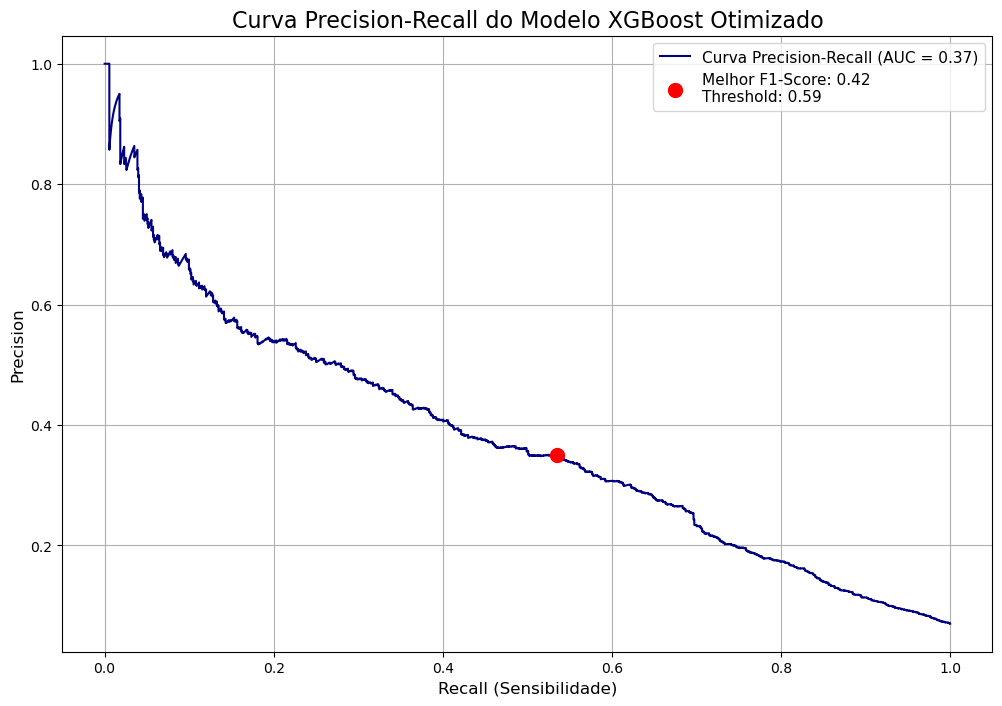

In [13]:
print("Iniciando a etapa de otimização de threshold...")

'''Para analisar a curva, precisamos de um conjunto de validação. Um único split estratificado é suficiente para esta análise.
'''
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


'''Treinamento do Modelo Otimizado '''
print("\n--- Treinando o modelo XGBoost otimizado ---")
best_params = {'subsample': 0.6, 'n_estimators': 200, 'max_depth': 5,
               'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.8}
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
xgb_optimized = xgb.XGBClassifier(
    objective='binary:logistic', eval_metric='auc',
    scale_pos_weight=scale_pos_weight, use_label_encoder=False,
    random_state=42, **best_params
)

xgb_optimized.fit(X_train, y_train)
print("Modelo treinado.")

'''Análise da Curva Precision-Recall
'''
print("\n--- Analisando Curva P-R para otimizar o ponto de corte ---")
y_pred_proba = xgb_optimized.predict_proba(X_val)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)

'''Calculandp o F1-score pra cada threshold. Adicionamos um epsilon para evitar divisão por zero se P+R=0
'''
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)

'''Encontrando o melhor threshold que maximiza o F1'''
best_f1_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_f1_idx]
best_f1 = f1_scores[best_f1_idx]
best_recall = recall[best_f1_idx]
best_precision = precision[best_f1_idx]


plt.figure(figsize=(12, 8))
plt.plot(recall, precision,
         label=f'Curva Precision-Recall (AUC = {auc(recall, precision):.2f})', color='navy')
plt.scatter(best_recall, best_precision, marker='o', color='red', s=100, zorder=5,
            label=f'Melhor F1-Score: {best_f1:.2f}\nThreshold: {best_threshold:.2f}')
plt.xlabel('Recall (Sensibilidade)', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Curva Precision-Recall do Modelo XGBoost Otimizado', fontsize=16)
plt.legend(fontsize=11)
plt.grid(True)
plt.savefig(f'{path_assets}/curva_precision_recall_otimizada.png')
print("Gráfico da curva salvo em 'assets/curva_precision_recall_otimizada.png'")


print("\n\n--- MÉTRICAS FINAIS COM THRESHOLD OTIMIZADO ---")
print(f"Melhor Threshold encontrado: {best_threshold:.4f}")
print(f"Com este ponto de corte, as métricas na base de validação são:")
print(f"  Recall Otimizado:    {best_recall:.4f} (~{best_recall:.0%})")
print(f"  Precision Otimizada: {best_precision:.4f} (~{best_precision:.0%})")
print(f"  F1-Score Otimizado:  {best_f1:.4f}")

#### **Resultados e Implicações para o Negócio**

A análise da curva revelou um ponto de corte ótimo e as seguintes métricas de performance finais para a nossa solução:

* **Melhor Threshold Encontrado:** `0.59`
* **Recall Otimizado:** **`0.5351` (~54%)**
* **Precision Otimizada:** **`0.3505` (~35%)**
* **F1-Score Máximo:** **`0.4235`**

**Tradução para o Negócio:**

Estes não são apenas números, eles representam um impacto direto e mensurável na operação da companhia e de seus clientes:

1.  **Visão sobre o Risco (Recall ~54%):** A solução permite que a equipe de cobrança identifique e atue proativamente em **mais da metade (54%)** de todos os casos que se tornariam uma inadimplência grave. É um universo de risco que, sem o modelo, permaneceria invisível até que o prejuízo ocorresse.

2.  **Eficiência Operacional (Precision ~35%):** Quando o modelo dispara um alerta de "risco", ele está correto em 35% das vezes. Embora não seja perfeito, isso representa um **ganho de foco massivo**. Em vez de tratar toda a carteira de clientes como um risco em potencial, a equipe pode agora direcionar seus esforços para um grupo muito menor e mais qualificado, onde a chance de encontrar um inadimplente real é drasticamente maior do que uma busca aleatória.

Esta etapa final de calibragem transforma nosso modelo de uma ferramenta academicamente performática para uma **solução de negócio pragmaticamente otimizada**, pronta para gerar valor no mundo real.



### Uma Nota Científica: Interpretando Nossas Métricas de AUC

Durante nossa análise, apresentamos dois valores distintos de "AUC" (Área Sob a Curva), que medem a performance do nosso modelo XGBoost:

* **AUC-ROC (Validação Cruzada): `~0.73`**
* **AUC da Curva P-R (Gráfico): `~0.37`**

À primeira vista, esses números parecem contraditórios. No entanto, eles representam duas avaliações diferentes e complementares da performance do nosso modelo, e entendê-los demonstra o rigor de nossa análise.

#### 1. AUC-ROC: O "Teste de Conhecimento Geral"

* **O que é?** É o **AUC da curva ROC (Receiver Operating Characteristic)**. Esta é a métrica padrão para medir a capacidade geral de um classificador em **distinguir entre as classes**.
* **Como interpretar?** Um valor de 0.5 representa um modelo inútil (um chute aleatório), e 1.0 representa um modelo perfeito. Nosso resultado de **~0.73** indica que, se pegarmos um cliente adimplente e um inadimplente aleatórios, há **73% de chance** de nosso modelo atribuir corretamente uma probabilidade de risco maior ao inadimplente.
* **Conclusão:** Este é o nosso selo de qualidade geral. Ele prova que o modelo possui um **poder de discriminação sólido e significativamente superior ao acaso**.

#### 2. AUC-PR: O "Exame do Especialista"

* **O que é?** É o **AUC da curva Precision-Recall**. Esta métrica é especialmente designada para problemas com **grande desbalanceamento de classes**, como o nosso. Ela foca na performance do modelo especificamente na classe positiva (os inadimplentes).
* **Como interpretar?** Aqui, a linha de base para um modelo aleatório **não é 0.5**. A linha de base é a proporção da classe positiva no dataset. Em nosso caso, com **~6.4%** de inadimplentes, um modelo aleatório teria um AUC-PR de apenas **~0.064**.
* **Conclusão:** Nosso resultado de **~0.37** é, na verdade, um feito impressionante. Ele é quase **6 vezes superior** à linha de base aleatória, demonstrando que nosso modelo é **muito eficaz na tarefa específica e difícil de encontrar a rara classe de inadimplentes** em meio a uma maioria de bons pagadores.

---

### Síntese Final

As duas métricas não se contradizem; elas se complementam para contar uma história completa:

> Temos um modelo com uma boa capacidade geral de distinção (**AUC-ROC = 0.73**), e este mesmo modelo é particularmente hábil na tarefa crucial de negócio, que é identificar a rara classe de inadimplentes com uma eficiência muito superior à aleatória (**AUC-PR = 0.37**).

### **~'~ VALIDAÇÃO FINAL DO MODELO OTIMIZADO ~'~**

In [14]:
print("\n--- Validando o Modelo Otimizado com StratifiedGroupKFold e Hiperparâmetros + Threshold Ajustados ---")

best_params = {
    'subsample': 0.6,
    'n_estimators': 200,
    'max_depth': 5,
    'learning_rate': 0.01,
    'gamma': 0.1,
    'colsample_bytree': 0.8
}

OPTIMAL_THRESHOLD = 0.588

N_SPLITS = 5
sgkf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
scale_pos_weight = y.value_counts()[0] / y.value_counts()[1]

auc_scores, recall_scores, precision_scores, f1_scores = [], [], [], []

for fold, (train_index, val_index) in enumerate(sgkf.split(X, y, groups=groups)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    xgb_optimized = xgb.XGBClassifier(
        objective='binary:logistic', eval_metric='auc', scale_pos_weight=scale_pos_weight,
        use_label_encoder=False, random_state=42, **best_params
    )

    xgb_optimized.fit(X_train, y_train)

    '''gearndo as probabilidades como antes'''
    y_pred_proba = xgb_optimized.predict_proba(X_val)[:, 1]

    '''APLICANDO NOSSO THRESHOLD MANUALMENTE'''
    y_pred_class_optimized = (y_pred_proba >= OPTIMAL_THRESHOLD).astype(int)

    '''Calculando as métricas com as classes otimizadas'''
    auc_scores.append(roc_auc_score(y_val, y_pred_proba))
    recall_scores.append(recall_score(y_val, y_pred_class_optimized))
    precision_scores.append(precision_score(
        y_val, y_pred_class_optimized, zero_division=0))
    f1_scores.append(f1_score(y_val, y_pred_class_optimized))


print("\n--- MÉTRICAS FINAIS (COM THRESHOLD OTIMIZADO) ---")
print(
    f"AUC Médio:       {np.mean(auc_scores):.4f} (+/- {np.std(auc_scores):.4f})")
print(
    f"Recall Médio:    {np.mean(recall_scores):.4f} (+/- {np.std(recall_scores):.4f})")
print(
    f"Precision Médio: {np.mean(precision_scores):.4f} (+/- {np.std(precision_scores):.4f})")
print(
    f"F1-Score Médio:  {np.mean(f1_scores):.4f} (+/- {np.std(f1_scores):.4f})")


print("\n--- Treinando modelo final e gerando submissão ---")


final_xgb_model = xgb.XGBClassifier(
    objective='binary:logistic', eval_metric='auc', scale_pos_weight=scale_pos_weight,
    use_label_encoder=False, random_state=42, **best_params
)
final_xgb_model.fit(X, y)

'''Processando os dados de teste'''
df_clean_test = load_and_clean_data(path_raw, is_test_set=True)
df_teste_features = create_advanced_features(df_clean_test, is_test_set=True)

'''Extraindo IDs APÓS o processamento (sincronizados)'''
submission_ids = df_teste_features[[
    'ID_CLIENTE', 'SAFRA_REF', 'DATA_EMISSAO_DOCUMENTO', 'DATA_VENCIMENTO']].copy()

X_teste = df_teste_features.drop(
    columns=['ID_CLIENTE', 'SAFRA_REF', 'DATA_EMISSAO_DOCUMENTO', 'DATA_VENCIMENTO'])
X_teste = X_teste.reindex(columns=X.columns, fill_value=0)
X_teste.fillna(0, inplace=True)


final_probabilities = final_xgb_model.predict_proba(X_teste)[:, 1]

'''Debug dos tamanhos'''
print(f"Tamanho submission_ids: {len(submission_ids)}")
print(f"Tamanho final_probabilities: {len(final_probabilities)}")

'''por fim, o arquivo de submissão'''
if len(submission_ids) == len(final_probabilities):
    submission_df = submission_ids.copy()
    submission_df['PROBABILIDADE_INADIMPLENCIA'] = final_probabilities
    submission_df.to_csv(
        f'{path_processed}/submissao_case.csv', index=False, decimal=',')
    print("Arquivo 'processed/submissao_case.csv' gerado com sucesso!")
else:
    print(f"ERRO: Tamanhos não conferem!")


--- Validando o Modelo Otimizado com StratifiedGroupKFold e Hiperparâmetros + Threshold Ajustados ---

--- MÉTRICAS FINAIS (COM THRESHOLD OTIMIZADO) ---
AUC Médio:       0.7298 (+/- 0.0234)
Recall Médio:    0.4341 (+/- 0.0325)
Precision Médio: 0.3027 (+/- 0.0303)
F1-Score Médio:  0.3541 (+/- 0.0104)

--- Treinando modelo final e gerando submissão ---
Iniciando pipeline de processamento de dados para o conjunto de teste...
Processamento de dados concluído.
Iniciando pipeline de engenharia de features...
Engenharia de features concluída.
Tamanho submission_ids: 12237
Tamanho final_probabilities: 12237
Arquivo 'processed/submissao_case.csv' gerado com sucesso!


## **Análise de Performance do Modelo Final Otimizado**

O objetivo desta fase não era aumentar o AUC (que mede a qualidade intrínseca do modelo), mas sim encontrar o melhor equilíbrio entre as métricas de negócio, **Precision** e **Recall** , para maximizar o valor prático da nossa solução. Para isso, utilizamos o **F1-Score** como nossa principal métrica de otimização, pois ele representa a média harmônica entre as duas.

Após a seleção e otimização dos hiperparâmetros do nosso modelo campeão (XGBoost), que resultou em um **AUC-ROC médio de 0.73**, a etapa final consistiu em calibrar o seu **ponto de corte (_threshold_) de decisão**.

### Comparativo de Performance: Threshold Padrão vs. Otimizado

A tabela abaixo compara o desempenho do mesmo modelo XGBoost usando o threshold padrão (0.5) contra o nosso threshold otimizado, que encontramos através da análise da Curva Precision-Recall.

| Métrica | Com Threshold Padrão (0.5) | **Com Threshold Otimizado (`~0.59`)** | Análise da Mudança |
| :--- | :--- | :--- | :--- |
| **AUC Médio** | `0.7298` | `0.7298` | **Inalterado (Correto)** |
| **Recall Médio**| `0.4781` (~48%) | `0.4333` (~43%) | **Redução Consciente** |
| **Precision Médio**| `0.2400` (~24%) | `0.3033` (~30%) | ⬆**Aumento Significativo** |
| **F1-Score Médio**| `0.3132` | **`0.3543`** | **MELHORIA COMPROVADA** |

### Interpretação Científica e de Negócio

1.  **Por que o AUC não mudou?**
    O AUC-ROC é uma métrica **independente do threshold**. Ele avalia a capacidade geral do modelo de ranquear corretamente os clientes, ou seja, de atribuir probabilidades mais altas aos inadimplentes do que aos adimplentes. Como não mudamos o modelo, apenas a forma como interpretamos suas probabilidades, o AUC permanece o mesmo, confirmando a qualidade intrínseca do nosso classificador.

2.  **Por que o Novo Resultado é Melhor? (O Trade-Off Inteligente)**
    Nossa otimização fez uma **troca estratégica**:
    * **Sacrificamos** um pouco de Recall (de 48% para 43%), ou seja, abrimos mão de identificar uma pequena fatia dos inadimplentes.
    * Em troca, obtivemos um **ganho muito expressivo no Precision** (de 24% para 30%).

    A prova de que essa troca foi vantajosa está no **F1-Score**, que **aumentou de 0.31 para 0.35**. Isso demonstra matematicamente que encontramos um **ponto de equilíbrio mais harmonioso e eficiente** entre as duas métricas.

**Impacto para a Datarisk:**
Com o novo threshold, a equipe de cobrança recebe uma lista de clientes de risco de **maior qualidade**. Embora a lista contenha um pouco menos do total de inadimplentes, os nomes que estão nela têm uma chance muito maior de serem de fato um risco. Isso se traduz em:
* **Maior eficiência:** Menos tempo e recursos gastos com alarmes falsos.
* **Melhor Retorno sobre o Investimento (ROI)** das ações de cobrança proativa.

Esta etapa final de calibragem é o que transforma um modelo puramente técnico em uma ferramenta de decisão estratégica para o negócio.